# Imports

In [1]:
import os
import copy
import numpy as np
import random
import torch
import module
from torchvision import transforms
from matplotlib import pyplot as plt
import time
import json
import seaborn as sns

def BI_LSE(zs, axis=0, class_axis=-1):
    '''
    Bregman Information of random variable Z generated by G = LSE
    BI_G [ Z ] = E[ G( Z ) ] - G( E[ Z ] )
    We estimate with dataset zs = [Z_1, ..., Z_n] via
    1/n sum_i G( Z_i ) - G( 1/n sum_i Z_i )
    
    Arg zs: Tensor with shape length >= 2
    Arg axis: Axis of the samples to average over
    Arg class_axis: Axis of the class logits
    Output: Tensor with shape length reduced by two
    '''
    E_of_LSE = zs.logsumexp(axis=class_axis).mean(axis)
    LSE_of_E = zs.mean(axis).unsqueeze(axis).logsumexp(axis=class_axis).squeeze(axis)
    return E_of_LSE - LSE_of_E

def softmax(logits):
    exp_logits = np.exp(logits - np.max(logits))  # Stabilität durch Subtrahieren des Maximums
    probabilities = exp_logits / np.sum(exp_logits)
    return probabilities

# Daten aufbereiten und Logits berechnen

In [2]:
logs = []
for _seed_ in range(1, 11):
    print(f"Mit seed {_seed_}")
    random.seed(_seed_)
    L = list(range(6))
    random.shuffle(L)
    draws_left = 60000
    for i in range(6):
        #print(L[i])
        if i != 5:
            ziehung = random.randint(0, draws_left)
            #print('ziehung', ziehung)
        else:
            ziehung = draws_left
        von = random.randint(0, 1000448-60000)
        #print('von', von)
        draws_left -= ziehung
        #print(f"Ziehe aus Datei {L[i]} {ziehung} Dateien. Von {von} bis {von+ziehung}")
        logs.append({"datei": L[i], "anzahl": ziehung, "von": von, "seed": _seed_})

Mit seed 1
Mit seed 2
Mit seed 3
Mit seed 4
Mit seed 5
Mit seed 6
Mit seed 7
Mit seed 8
Mit seed 9
Mit seed 10


In [3]:
# Datei 0 hat Länge 1000448
# Datei 1 hat Länge 1000448
# Datei 2 hat Länge 1000448
# Datei 3 hat Länge 1000448
# Datei 4 hat Länge 1000448
# Datei 5 hat Länge 1000448
ueberschnitten = 0
def set_entries_to_zero(lst, x, y):
    for i in range(x, y):
        if lst[i] == 1:
            global ueberschnitten
            ueberschnitten += 1
        lst[i] = 1

file_0 = [0]*1000448
file_1 = [0]*1000448
file_2 = [0]*1000448
file_3 = [0]*1000448
file_4 = [0]*1000448
file_5 = [0]*1000448
all_files = [file_0, file_1, file_2, file_3, file_4, file_5]

In [4]:
for log in logs:
    current_file = all_files[log["datei"]]
    set_entries_to_zero(current_file, log["von"], log["von"]+log["anzahl"])
    #all_files[log["datei"]] = current_file
print(ueberschnitten)

20757


In [5]:
summesumme = 0
for i in range(6):
    summe = 0
    for log in logs:
        if log["datei"] == i:
            summe += log["anzahl"]
    summesumme += summe
    print(summe)
print(summesumme)

149717
79789
112729
70039
12100
175626
600000


In [6]:
def not_used_in_traning(file_num, ab):
    global all_files
    lst = all_files[file_num]
    for i in range(von, von+1000):
        if lst[i]:
            return False
    return True

In [7]:
random.seed(42)
for i in range(6):
    data_dict = np.load(f'../cifar5m_data/cifar5m_part{i}.npz', allow_pickle=True)
    darf_ziehen = False
    while not darf_ziehen:
        von = random.randint(0, 1000448-10000)
        darf_ziehen = not_used_in_traning(i, von)
    print(f"Aus Datei {i} wurden die Dateien {von} bis {von+10000} gezogen")
    if i == 0:
        test_data_x = data_dict["X"][von:von+10000]
        test_data_y = data_dict["Y"][von:von+10000]
    else:
        test_data_x = np.concatenate((test_data_x, data_dict["X"][von:von+10000]))
        test_data_y = np.concatenate((test_data_y, data_dict["Y"][von:von+10000]))
    del data_dict
    

Aus Datei 0 wurden die Dateien 670487 bis 680487 gezogen
Aus Datei 1 wurden die Dateien 116739 bis 126739 gezogen
Aus Datei 2 wurden die Dateien 26225 bis 36225 gezogen
Aus Datei 3 wurden die Dateien 777572 bis 787572 gezogen
Aus Datei 4 wurden die Dateien 288389 bis 298389 gezogen
Aus Datei 5 wurden die Dateien 256787 bis 266787 gezogen


In [8]:
dict_0_25k = dict()
for dp in test_data_y[:10000]:
    if dp in dict_0_25k:
        dict_0_25k[dp] += 1
    else:
        dict_0_25k[dp] = 1

   
print(dict_0_25k)

{7: 1125, 4: 962, 3: 957, 1: 1203, 6: 1058, 2: 878, 5: 899, 9: 1011, 8: 1065, 0: 842}


In [14]:
def evaluate_bootstrap_models(model_epoch, test_data_x):
    result_dict = dict()
    for seed in range(1, 11):
        model_name = "ResNet"
        checkpoint_path = f"../saved_models/epoch_{model_epoch}"
        save_name = model_name + '_seed{}'.format(seed)
        pretrained_filename = os.path.join(checkpoint_path, save_name + ".ckpt")
        model = module.CIFARModule.load_from_checkpoint(pretrained_filename)

        dataset = np.load(f"../saved_models/epoch_{model_epoch}/data_epoch_{model_epoch}_{seed}.npz")
        dataset = dataset["x"]
        dataset = torch.from_numpy(dataset).type(torch.float).transpose(-1, 1)

        DATA_MEANS = (dataset / 255.0).mean(axis=(0, 2, 3))
        DATA_STD = (dataset / 255.0).std(axis=(0, 2, 3))

        model.eval()

        #for i in range(100):
        for i in range(1000):
            data_point = torch.from_numpy(test_data_x[i*10:(i+1)*10]).type(torch.float).transpose(-1, 1)
            data_point = transforms.Normalize(DATA_MEANS, DATA_STD)(data_point)

            with torch.no_grad():
                output = model(data_point)
                
            output = output.numpy().tolist()
            #output = float(BI_LSE(output))
            
            if f"epoch_{model_epoch}_seed_{seed}" in result_dict:
                result_dict[f"epoch_{model_epoch}_seed_{seed}"].append(output)
            else:
                result_dict[f"epoch_{model_epoch}_seed_{seed}"] = [output]

    return result_dict

def get_cifar_data(seed):
    random.seed(seed)
    L = list(range(6))
    random.shuffle(L)
    draws_left = 60000
    for i in range(6):
        #print(L[i])
        data_dict = np.load(f'../cifar5m_data/cifar5m_part{L[i]}.npz', allow_pickle=True)
        if i != 5:
            ziehung = random.randint(0, draws_left)
            #print('ziehung', ziehung)
        else:
            ziehung = draws_left
        von = random.randint(0, 1000448-60000)
        #print('von', von)
        draws_left -= ziehung
        if i == 0:
            x = data_dict["X"][von:von+ziehung]
            y = data_dict["Y"][von:von+ziehung]
        else:
            x = np.concatenate((x, data_dict["X"][von:von+ziehung]))
            y = np.concatenate((y, data_dict["Y"][von:von+ziehung]))
        del data_dict
    del y
    return x[:45000]

def evaluate_cifar_models(test_data_x):
    #start_time = time.time()
    # load model
    result_dict = dict()
    for seed in [1,2,3,4,5,6,7,8,9,11]:
    #for seed in [10]:
        model_name = "ResNet"
        checkpoint_path = f"../saved_models/CIFAR5m"
        save_name = model_name + '_seed{}'.format(seed)
        pretrained_filename = os.path.join(checkpoint_path, save_name + ".ckpt")
        model = module.CIFARModule.load_from_checkpoint(pretrained_filename)

        dataset = get_cifar_data(seed)
        dataset = torch.from_numpy(dataset).type(torch.float).transpose(-1, 1)

        DATA_MEANS = (dataset / 255.0).mean(axis=(0, 2, 3))
        DATA_STD = (dataset / 255.0).std(axis=(0, 2, 3))

        model.eval()
        #for i in range(100):
        for i in range(1000):
            data_point = torch.from_numpy(test_data_x[i*10:(i+1)*10]).type(torch.float).transpose(-1, 1)
            data_point = transforms.Normalize(DATA_MEANS, DATA_STD)(data_point)

            with torch.no_grad():
                output = model(data_point)
                
            output = output.numpy().tolist()
            #output = float(BI_LSE(output))
            
            if f"cifar_seed_{seed}" in result_dict:
                result_dict[f"cifar_seed_{seed}"].append(output)
            else:
                result_dict[f"cifar_seed_{seed}"] = [output]
    return result_dict

def evaluate_other_cifar_models(test_data_x):
    #start_time = time.time()
    # load model
    result_dict = dict()
    for seed in range(1,11):
    #for seed in [10]:
        model_name = "ResNet"
        checkpoint_path = f"../saved_models/CIFAR5m_subset_seed_7"
        save_name = model_name + '_seed{}'.format(seed)
        pretrained_filename = os.path.join(checkpoint_path, save_name + ".ckpt")
        model = module.CIFARModule.load_from_checkpoint(pretrained_filename)

        dataset = get_cifar_data(7)
        dataset = torch.from_numpy(dataset).type(torch.float).transpose(-1, 1)

        DATA_MEANS = (dataset / 255.0).mean(axis=(0, 2, 3))
        DATA_STD = (dataset / 255.0).std(axis=(0, 2, 3))

        model.eval()
        #for i in range(100):
        for i in range(1000):
            data_point = torch.from_numpy(test_data_x[i*10:(i+1)*10]).type(torch.float).transpose(-1, 1)
            data_point = transforms.Normalize(DATA_MEANS, DATA_STD)(data_point)

            with torch.no_grad():
                output = model(data_point)
                
            output = output.numpy().tolist()
            #output = float(BI_LSE(output))
            
            if f"cifar_seed_{seed}" in result_dict:
                result_dict[f"cifar_seed_{seed}"].append(output)
            else:
                result_dict[f"cifar_seed_{seed}"] = [output]
    return result_dict

In [15]:
#result_dict = evaluate_bootstrap_models(150, test_data_x)
#result_dict = evaluate_other_cifar_models(test_data_x)

In [16]:
# file_path = "ergebnisse/logits_other_cifar.json"

# # Save the dictionary as JSON
# with open(file_path, "w") as json_file:
#     json.dump(result_dict, json_file)

# Visualisierung der Daten

In [8]:
def ergebnis_plot(ergebnis):
    plt.hist(ergebnis, bins=100, edgecolor='black')
    print("mean", np.mean(ergebnis))
    print("std", np.std(ergebnis))
    print("var", np.var(ergebnis))
    plt.xlabel('Float-values')
    plt.ylabel('count')
    plt.title('Distribution')
    plt.grid(True)
    plt.show()
    
def ergebnis_log_plot(ergebnis):
    ergebnis = [i if i != 0 else 1e-5 for i in ergebnis]
    plt.hist(np.log(ergebnis), bins=100, edgecolor='black')
    print("mean", np.mean(ergebnis))
    print("std", np.std(ergebnis))
    print("var", np.var(ergebnis))
    plt.xlabel('Float-values')
    plt.ylabel('count')
    plt.title('Distribution')
    plt.grid(True)
    plt.show()

def get_logits_json(was):
    with open(f'ergebnisse/logits_{was}.json', 'r') as f:
      data = json.load(f)
    return data

## Alle Datenpunkte

### 150

mean 0.18447190974712374
std 0.23528676136608667
var 0.05535986007414182


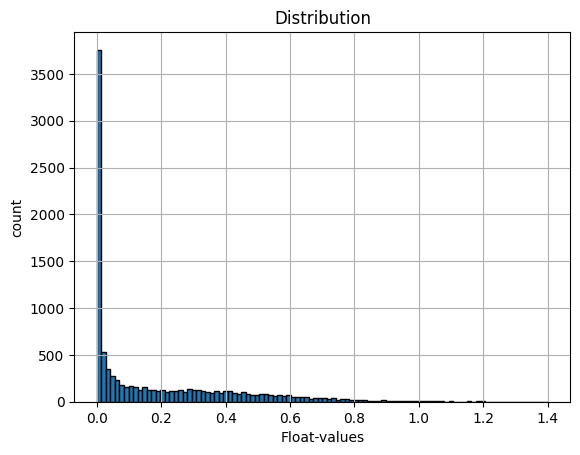

mean 0.18447190974712374
std 0.23528676136608667
var 0.05535986007414182


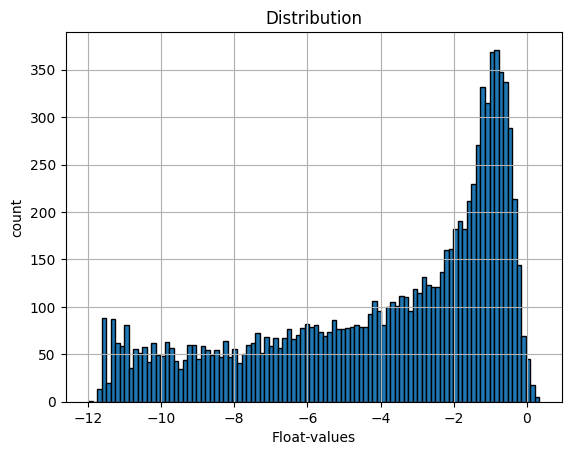

In [9]:
logits_150 = get_logits_json(150)
bi_results = []
for h in range(1000):
    for d in range(10):
        L = []
        for i in range(1, 11):
            L.append(logits_150[f"epoch_150_seed_{i}"][h][d])
        L = torch.tensor(L)
        bi_results.append(float(BI_LSE(L)) + .00001)
ergebnis_plot(bi_results)
ergebnis_log_plot(bi_results)

### 250

mean 0.17846238179206847
std 0.23330144516145462
var 0.05442956431442322


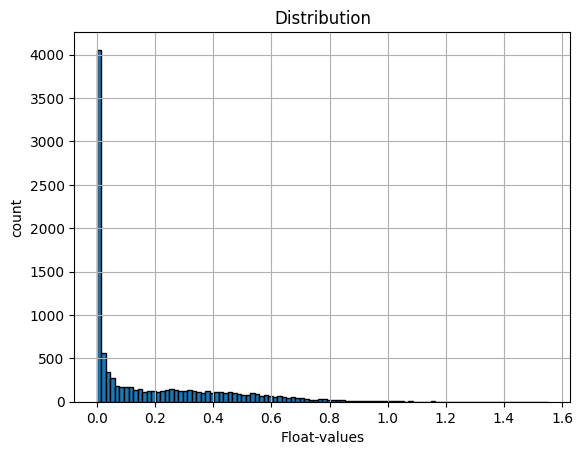

/tmp/ipykernel_2182686/1813098788.py:14: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(ergebnis), bins=100, edgecolor='black')


mean 0.17846251979206848
std 0.23330133960216948
var 0.05442951506016681


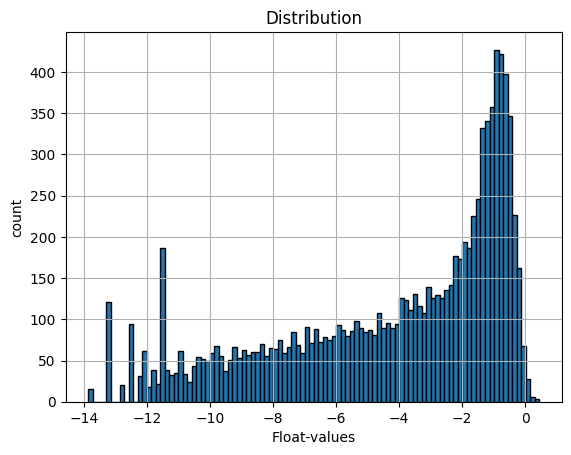

In [10]:
logits_250 = get_logits_json(250)
bi_results = []
for h in range(1000):
    for d in range(10):
        L = []
        for i in range(1, 11):
            L.append(logits_250[f"epoch_250_seed_{i}"][h][d])
        L = torch.tensor(L)
        bi_results.append(float(BI_LSE(L)))
ergebnis_plot(bi_results)
ergebnis_log_plot(bi_results)

### 500

mean 0.17833606157302856
std 0.23704259500072095
var 0.056189191844675815


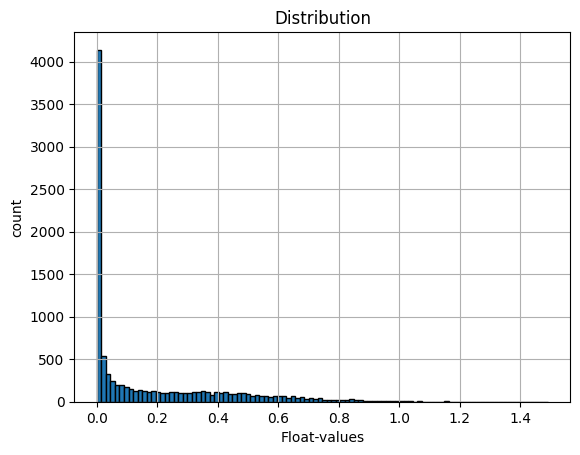

/tmp/ipykernel_2182686/1813098788.py:14: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(ergebnis), bins=100, edgecolor='black')


mean 0.17833622457302858
std 0.23704247237303946
var 0.05618913370872317


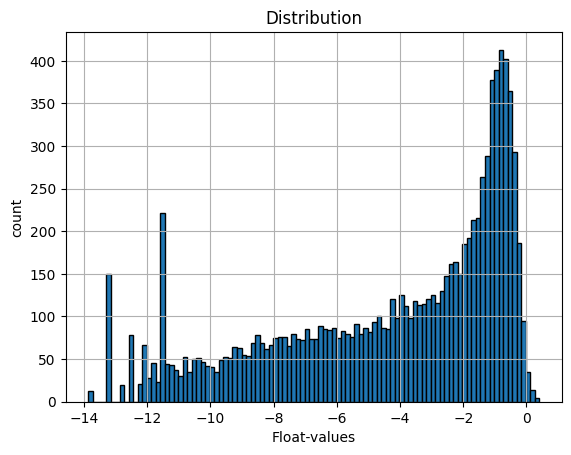

In [11]:
logits_500 = get_logits_json(500)
bi_results = []
for h in range(1000):
    for d in range(10):
        L = []
        for i in range(1, 11):
            L.append(logits_500[f"epoch_500_seed_{i}"][h][d])
        L = torch.tensor(L)
        bi_results.append(float(BI_LSE(L)))
ergebnis_plot(bi_results)
ergebnis_log_plot(bi_results)

### 700

mean 0.19036801755428315
std 0.2538066171855247
var 0.06441779892715949


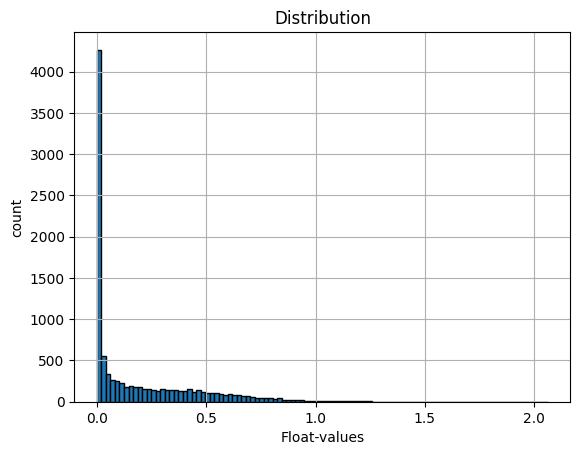

/tmp/ipykernel_2182686/1813098788.py:14: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(ergebnis), bins=100, edgecolor='black')


mean 0.19036815355428313
std 0.2538065151811517
var 0.0644177471484002


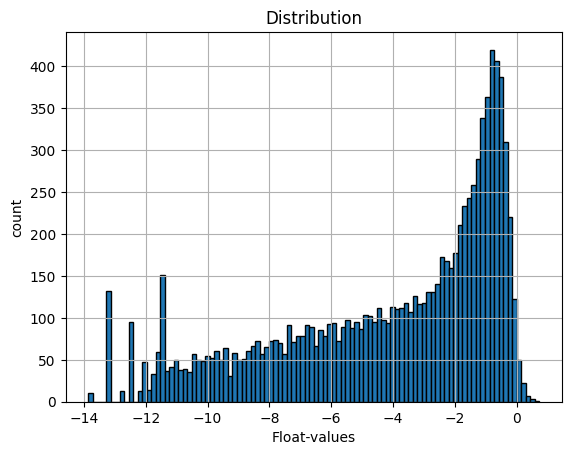

In [12]:
logits_700 = get_logits_json(700)
bi_results = []
for h in range(1000):
    for d in range(10):
        L = []
        for i in range(1, 11):
            L.append(logits_700[f"epoch_700_seed_{i}"][h][d])
        L = torch.tensor(L)
        bi_results.append(float(BI_LSE(L)))
ergebnis_plot(bi_results)
ergebnis_log_plot(bi_results)

### Cifar

mean 0.2500410905122757
std 0.43245108152402884
var 0.18701393791130225


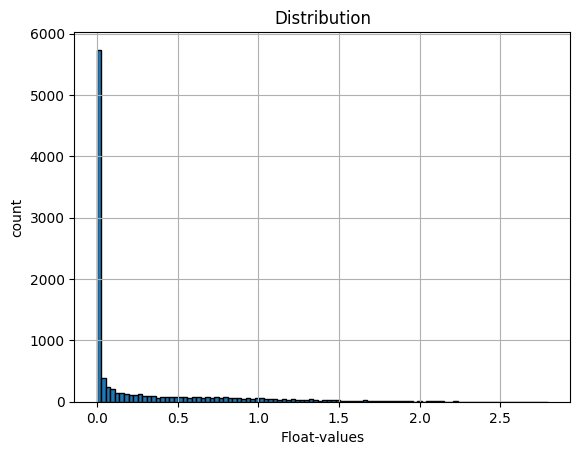

/tmp/ipykernel_2182686/1813098788.py:14: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(ergebnis), bins=100, edgecolor='black')


mean 0.25004179551227573
std 0.43245067390387726
var 0.18701358535991758


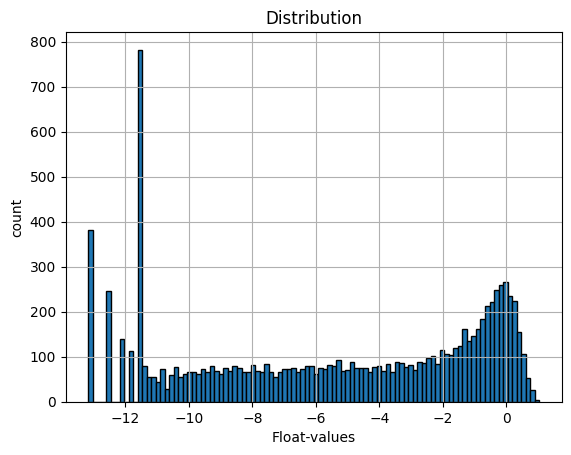

In [13]:
logits_cifar = get_logits_json("cifar")
bi_results = []
for h in range(1000):
    for d in range(10):
        L = []
        for i in [1,2,3,4,5,6,7,8,9,11]:
            L.append(logits_cifar[f"cifar_seed_{i}"][h][d])
        L = torch.tensor(L)
        bi_results.append(float(BI_LSE(L)))
ergebnis_plot(bi_results)
ergebnis_log_plot(bi_results)

### deep ensemble

mean 0.20478980729579926
std 0.3619060540806274
var 0.13097599198021004


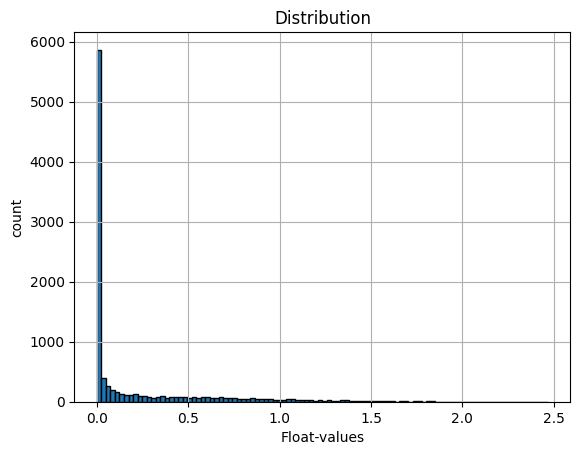

/tmp/ipykernel_2182686/1813098788.py:14: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(ergebnis), bins=100, edgecolor='black')


mean 0.20479060629579926
std 0.36190560196472443
var 0.13097566473344957


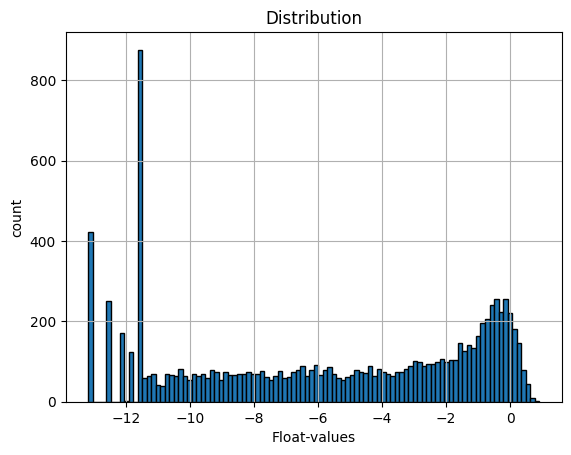

In [14]:
other_logits_cifar = get_logits_json("other_cifar")
bi_results = []
for h in range(1000):
    for d in range(10):
        L = []
        for i in range(1,11):
            L.append(other_logits_cifar[f"cifar_seed_{i}"][h][d])
        L = torch.tensor(L)
        bi_results.append(float(BI_LSE(L)))
ergebnis_plot(bi_results)
ergebnis_log_plot(bi_results)

## Genauigkeit

### average logits

In [15]:
alle_logits = [logits_150, logits_250, logits_500, logits_700]
key_strings = ["epoch_150_seed_", "epoch_250_seed_", "epoch_500_seed_", "epoch_700_seed_"]
result_dict_acc = {}
for ekato in range(1000):
    for deka in range(10):
        for model_logits, model_key in zip(alle_logits, key_strings):
            ensemble = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
            for model_seed in range(1, 11):
                ein_logit = model_logits[model_key+str(model_seed)][ekato][deka]
                ensemble += np.array(ein_logit)
            ensemble = ensemble / 10
            result = softmax(ensemble)
            result = result.tolist().index(max(result))
            if model_key in result_dict_acc:
                result_dict_acc[model_key].append(result)
            else:
                result_dict_acc[model_key] = [result]

cifar_ensemble_acc = []
for ekato in range(1000):
    for deka in range(10):
        ensemble = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
        for model_seed in [1,2,3,4,5,6,7,8,9,11]:
            ein_logit = logits_cifar["cifar_seed_"+str(model_seed)][ekato][deka]
            ensemble += np.array(ein_logit)
        ensemble = ensemble / 10
        result = softmax(ensemble)
        result = result.tolist().index(max(result))
        cifar_ensemble_acc.append(result)
        
other_cifar_ensemble_acc = []
for ekato in range(1000):
    for deka in range(10):
        ensemble = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
        for model_seed in range(1,11):
            ein_logit = other_logits_cifar["cifar_seed_"+str(model_seed)][ekato][deka]
            ensemble += np.array(ein_logit)
        ensemble = ensemble / 10
        result = softmax(ensemble)
        result = result.tolist().index(max(result))
        other_cifar_ensemble_acc.append(result)

### average softmax

In [16]:
alle_logits = [logits_150, logits_250, logits_500, logits_700]
key_strings = ["epoch_150_seed_", "epoch_250_seed_", "epoch_500_seed_", "epoch_700_seed_"]
result_dict_acc = {}
for ekato in range(1000):
    for deka in range(10):
        for model_logits, model_key in zip(alle_logits, key_strings):
            ensemble = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
            for model_seed in range(1, 11):
                ein_logit = model_logits[model_key+str(model_seed)][ekato][deka]
                ensemble += np.array(softmax(ein_logit))
            ensemble = ensemble / 10
            #result = softmax(ensemble)
            result = ensemble.tolist().index(max(ensemble))
            if model_key in result_dict_acc:
                result_dict_acc[model_key].append(result)
            else:
                result_dict_acc[model_key] = [result]

cifar_ensemble_acc = []
for ekato in range(1000):
    for deka in range(10):
        ensemble = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
        for model_seed in [1,2,3,4,5,6,7,8,9,11]:
            ein_logit = logits_cifar["cifar_seed_"+str(model_seed)][ekato][deka]
            ensemble += np.array(softmax(ein_logit))
        ensemble = ensemble / 10
        #result = softmax(ensemble)
        result = ensemble.tolist().index(max(ensemble))
        cifar_ensemble_acc.append(result)
        
other_cifar_ensemble_acc = []
for ekato in range(1000):
    for deka in range(10):
        ensemble = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
        for model_seed in range(1,11):
            ein_logit = other_logits_cifar["cifar_seed_"+str(model_seed)][ekato][deka]
            ensemble += np.array(softmax(ein_logit))
        ensemble = ensemble / 10
        #result = softmax(ensemble)
        result = ensemble.tolist().index(max(ensemble))
        other_cifar_ensemble_acc.append(result)

In [110]:
test_data_y

60000

### 150

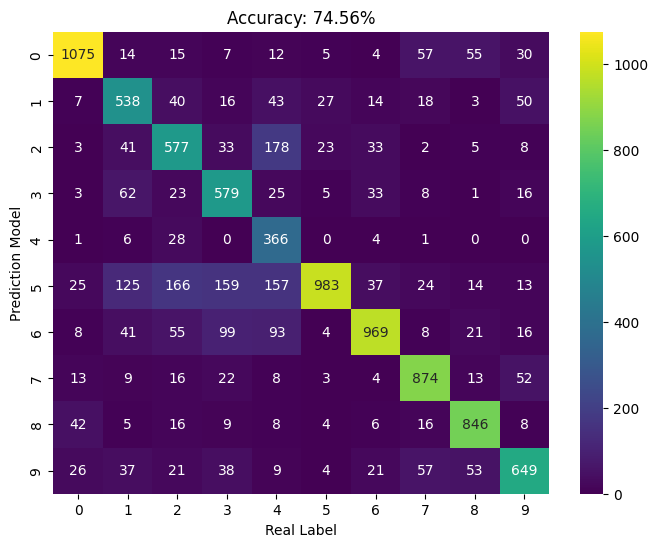

In [17]:
# Erstellen Sie eine leere 10x10 Matrix für die Heatmap
heatmap_matrix = np.zeros((10, 10), dtype=int)

# Zählen Sie die Kombinationen der Zahlen aus den Arrays und aktualisieren Sie die Heatmap-Matrix
for num1, num2 in zip(result_dict_acc["epoch_150_seed_"], test_data_y):
    heatmap_matrix[num1 - 1, num2 - 1] += 1
    
diagonal_values = np.diagonal(heatmap_matrix)
diagonal_sum = np.sum(diagonal_values)

# Berechnen Sie die prozentuale Anzahl der Werte auf der Hauptdiagonalen
total_values = np.sum(heatmap_matrix)
diagonal_percentage = (diagonal_sum / total_values) * 100

# Erstellen Sie die Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_matrix, annot=True, fmt="d", cmap='viridis')
plt.xlabel('Real Label')
plt.ylabel('Prediction Model')
plt.title(f'Accuracy: {diagonal_percentage:.2f}%')
plt.show()

### 250

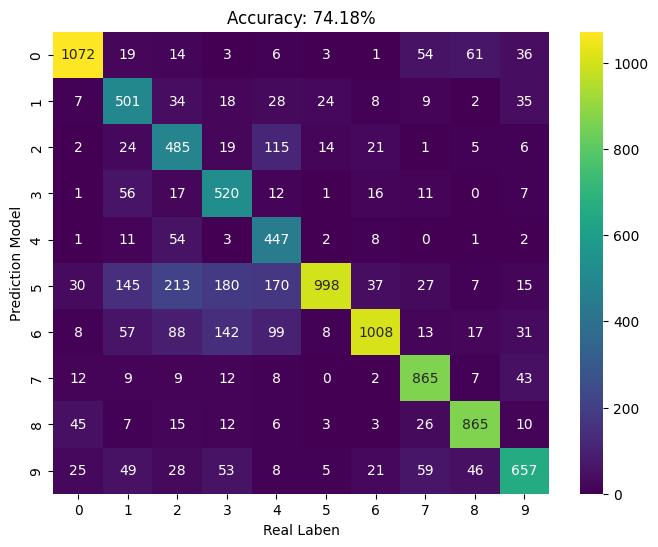

In [18]:
# Erstellen Sie eine leere 10x10 Matrix für die Heatmap
heatmap_matrix = np.zeros((10, 10), dtype=int)

# Zählen Sie die Kombinationen der Zahlen aus den Arrays und aktualisieren Sie die Heatmap-Matrix
for num1, num2 in zip(result_dict_acc["epoch_250_seed_"], test_data_y):
    heatmap_matrix[num1 - 1, num2 - 1] += 1
    
diagonal_values = np.diagonal(heatmap_matrix)
diagonal_sum = np.sum(diagonal_values)

# Berechnen Sie die prozentuale Anzahl der Werte auf der Hauptdiagonalen
total_values = np.sum(heatmap_matrix)
diagonal_percentage = (diagonal_sum / total_values) * 100

# Erstellen Sie die Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_matrix, annot=True, fmt="d", cmap='viridis')
plt.xlabel('Real Laben')
plt.ylabel('Prediction Model')
plt.title(f'Accuracy: {diagonal_percentage:.2f}%')
plt.show()

### 500

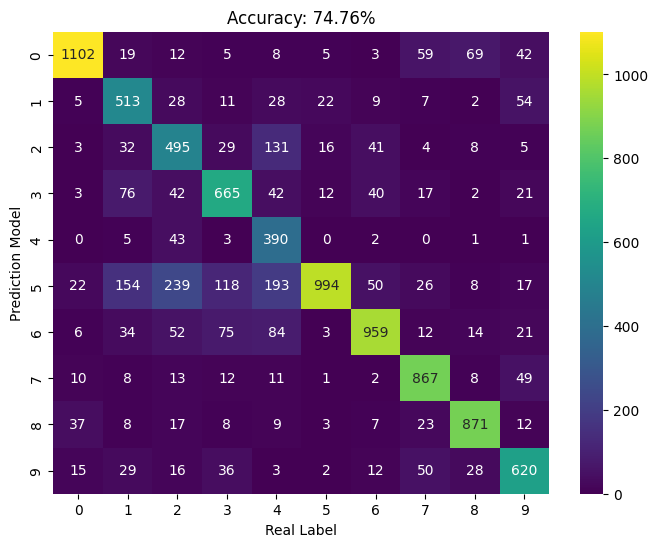

In [19]:
# Erstellen Sie eine leere 10x10 Matrix für die Heatmap
heatmap_matrix = np.zeros((10, 10), dtype=int)

# Zählen Sie die Kombinationen der Zahlen aus den Arrays und aktualisieren Sie die Heatmap-Matrix
for num1, num2 in zip(result_dict_acc["epoch_500_seed_"], test_data_y):
    heatmap_matrix[num1 - 1, num2 - 1] += 1
    
diagonal_values = np.diagonal(heatmap_matrix)
diagonal_sum = np.sum(diagonal_values)

# Berechnen Sie die prozentuale Anzahl der Werte auf der Hauptdiagonalen
total_values = np.sum(heatmap_matrix)
diagonal_percentage = (diagonal_sum / total_values) * 100

# Erstellen Sie die Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_matrix, annot=True, fmt="d", cmap='viridis')
plt.xlabel('Real Label')
plt.ylabel('Prediction Model')
plt.title(f'Accuracy: {diagonal_percentage:.2f}%')
plt.show()

### 700

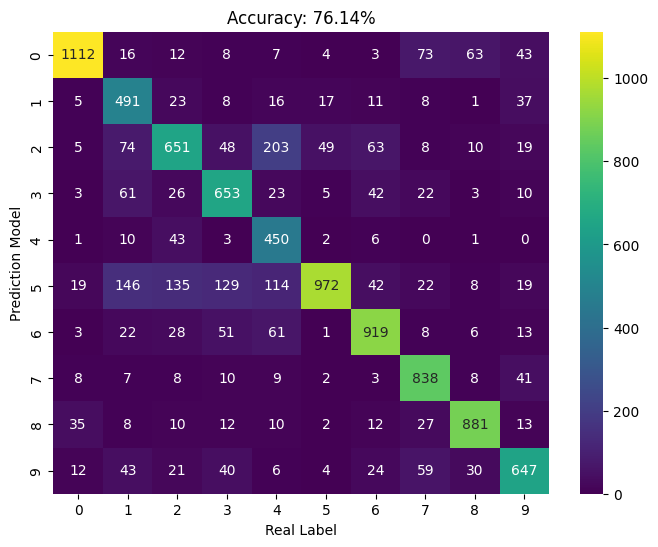

In [20]:
# Erstellen Sie eine leere 10x10 Matrix für die Heatmap
heatmap_matrix = np.zeros((10, 10), dtype=int)

# Zählen Sie die Kombinationen der Zahlen aus den Arrays und aktualisieren Sie die Heatmap-Matrix
for num1, num2 in zip(result_dict_acc["epoch_700_seed_"], test_data_y):
    heatmap_matrix[num1 - 1, num2 - 1] += 1
    
diagonal_values = np.diagonal(heatmap_matrix)
diagonal_sum = np.sum(diagonal_values)

# Berechnen Sie die prozentuale Anzahl der Werte auf der Hauptdiagonalen
total_values = np.sum(heatmap_matrix)
diagonal_percentage = (diagonal_sum / total_values) * 100

# Erstellen Sie die Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_matrix, annot=True, fmt="d", cmap='viridis')
plt.xlabel('Real Label')
plt.ylabel('Prediction Model')
plt.title(f'Accuracy: {diagonal_percentage:.2f}%')
plt.show()

### cifar

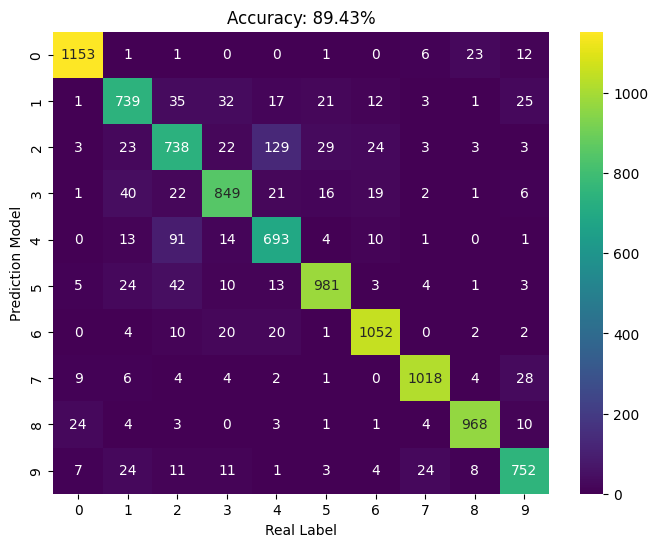

In [21]:
# Erstellen Sie eine leere 10x10 Matrix für die Heatmap
heatmap_matrix = np.zeros((10, 10), dtype=int)

# Zählen Sie die Kombinationen der Zahlen aus den Arrays und aktualisieren Sie die Heatmap-Matrix
for num1, num2 in zip(cifar_ensemble_acc, test_data_y):
    heatmap_matrix[num1 - 1, num2 - 1] += 1
    
diagonal_values = np.diagonal(heatmap_matrix)
diagonal_sum = np.sum(diagonal_values)

# Berechnen Sie die prozentuale Anzahl der Werte auf der Hauptdiagonalen
total_values = np.sum(heatmap_matrix)
diagonal_percentage = (diagonal_sum / total_values) * 100

# Erstellen Sie die Heatmap mit seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_matrix, annot=True, fmt="d", cmap='viridis')
plt.xlabel('Real Label')
plt.ylabel('Prediction Model')
plt.title(f'Accuracy: {diagonal_percentage:.2f}%')
plt.show()

### deep ensemble 

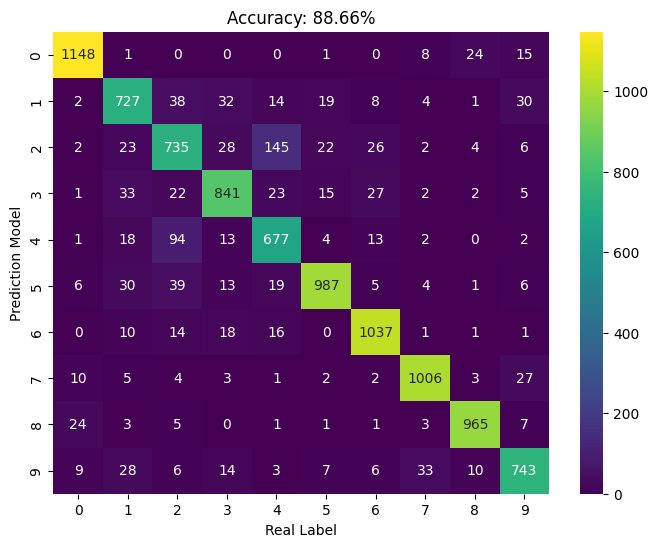

In [22]:
# Erstellen Sie eine leere 10x10 Matrix für die Heatmap
heatmap_matrix = np.zeros((10, 10), dtype=int)

# Zählen Sie die Kombinationen der Zahlen aus den Arrays und aktualisieren Sie die Heatmap-Matrix
for num1, num2 in zip(other_cifar_ensemble_acc, test_data_y):
    heatmap_matrix[num1 - 1, num2 - 1] += 1
    
diagonal_values = np.diagonal(heatmap_matrix)
diagonal_sum = np.sum(diagonal_values)

# Berechnen Sie die prozentuale Anzahl der Werte auf der Hauptdiagonalen
total_values = np.sum(heatmap_matrix)
diagonal_percentage = (diagonal_sum / total_values) * 100

# Erstellen Sie die Heatmap mit seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_matrix, annot=True, fmt="d", cmap='viridis')
plt.xlabel('Real Label')
plt.ylabel('Prediction Model')
plt.title(f'Accuracy: {diagonal_percentage:.2f}%')
plt.show()

## Confidence

### 150

#### average logits

In [22]:
alle_logits = [logits_150, logits_250, logits_500, logits_700]
key_strings = ["epoch_150_seed_", "epoch_250_seed_", "epoch_500_seed_", "epoch_700_seed_"]
result_dict_conf = {}
for ekato in range(1000):
    for deka in range(10):
        for model_logits, model_key in zip(alle_logits, key_strings):
            ensemble = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
            for model_seed in range(1, 11):
                ein_logit = model_logits[model_key+str(model_seed)][ekato][deka]
                ensemble += np.array(ein_logit)
            ensemble = ensemble / 10
            result = softmax(ensemble)
            result = (result.tolist().index(max(result)), max(result))
            if model_key in result_dict_conf:
                result_dict_conf[model_key].append(result)
            else:
                result_dict_conf[model_key] = [result]

cifar_ensemble_conf = []
for ekato in range(1000):
    for deka in range(10):
        ensemble = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
        for model_seed in [1,2,3,4,5,6,7,8,9,11]:
            ein_logit = logits_cifar["cifar_seed_"+str(model_seed)][ekato][deka]
            ensemble += np.array(ein_logit)
        ensemble = ensemble / 10
        result = softmax(ensemble)
        result = (result.tolist().index(max(result)), max(result))
        cifar_ensemble_conf.append(result)
        
other_cifar_ensemble_conf = []
for ekato in range(1000):
    for deka in range(10):
        ensemble = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
        for model_seed in range(1,11):
            ein_logit = other_logits_cifar["cifar_seed_"+str(model_seed)][ekato][deka]
            ensemble += np.array(ein_logit)
        ensemble = ensemble / 10
        result = softmax(ensemble)
        result = (result.tolist().index(max(result)), max(result))
        other_cifar_ensemble_conf.append(result)

#### average softmax

In [23]:
alle_logits = [logits_150, logits_250, logits_500, logits_700]
key_strings = ["epoch_150_seed_", "epoch_250_seed_", "epoch_500_seed_", "epoch_700_seed_"]
result_dict_conf = {}
for ekato in range(1000):
    for deka in range(10):
        for model_logits, model_key in zip(alle_logits, key_strings):
            ensemble = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
            for model_seed in range(1, 11):
                ein_logit = model_logits[model_key+str(model_seed)][ekato][deka]
                ensemble += np.array(softmax(ein_logit))
            ensemble = ensemble / 10
           # result = softmax(ensemble)
            result = (ensemble.tolist().index(max(ensemble)), max(ensemble))
            if model_key in result_dict_conf:
                result_dict_conf[model_key].append(result)
            else:
                result_dict_conf[model_key] = [result]

cifar_ensemble_conf = []
for ekato in range(1000):
    for deka in range(10):
        ensemble = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
        for model_seed in [1,2,3,4,5,6,7,8,9,11]:
            ein_logit = logits_cifar["cifar_seed_"+str(model_seed)][ekato][deka]
            ensemble += np.array(softmax(ein_logit))
        ensemble = ensemble / 10
        #result = softmax(ensemble)
        result = (ensemble.tolist().index(max(ensemble)), max(ensemble))
        cifar_ensemble_conf.append(result)
        
other_cifar_ensemble_conf = []
for ekato in range(1000):
    for deka in range(10):
        ensemble = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
        for model_seed in range(1,11):
            ein_logit = other_logits_cifar["cifar_seed_"+str(model_seed)][ekato][deka]
            ensemble += np.array(softmax(ein_logit))
        ensemble = ensemble / 10
        #result = softmax(ensemble)
        result = (ensemble.tolist().index(max(ensemble)), max(ensemble))
        other_cifar_ensemble_conf.append(result)

plt.boxplot(data)
plt.title('Boxplot Beispiel')
plt.ylabel('Werte')
plt.show()#### Distribution all datapoints

mean 0.8269248847096856
std 0.20425140099719202
var 0.04171863480931574


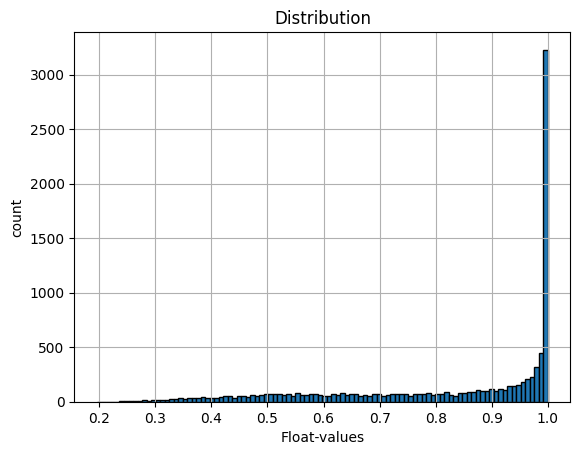

In [24]:
ergebnis_plot([i [1] for i in result_dict_conf["epoch_150_seed_"]])

#### Distribution of correctly classified

mean 0.8876087293439237
std 0.16535259984373354
var 0.027341482275081867


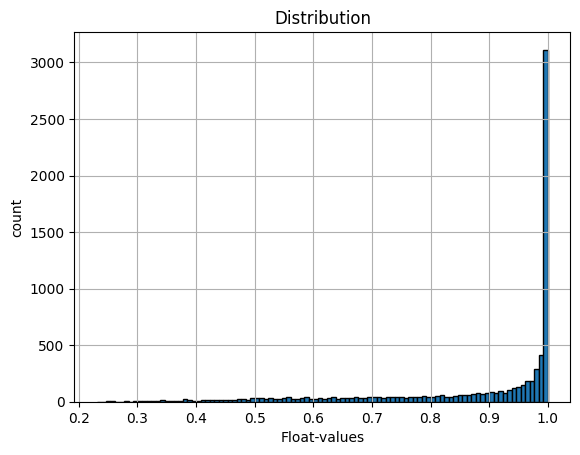

In [25]:
richtiges_label = []
for label, output in zip(test_data_y, result_dict_conf["epoch_150_seed_"]):
    if label == output[0]:
        richtiges_label.append(output[1])
ergebnis_plot(richtiges_label)

#### Distribution of misclassified

mean 0.6490716042093411
std 0.20354566173933047
var 0.04143083641290194


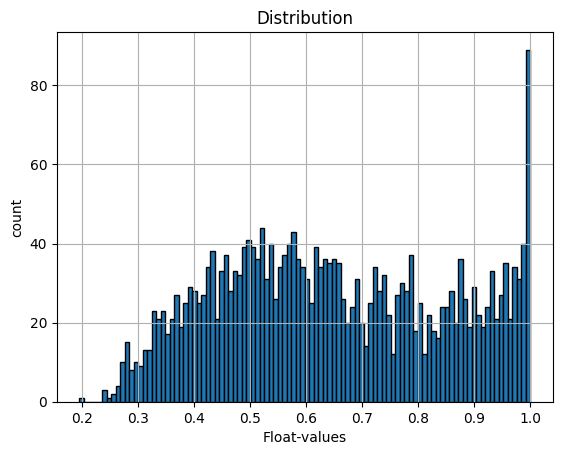

In [26]:
falsches_label = []
for label, output in zip(test_data_y, result_dict_conf["epoch_150_seed_"]):
    if label != output[0]:
        falsches_label.append(output[1])
ergebnis_plot(falsches_label)

#### Distribution difference to cifar5m ensemble models

mean 0.054070872077901254
std 0.19712702333006568
var 0.038859063326972254


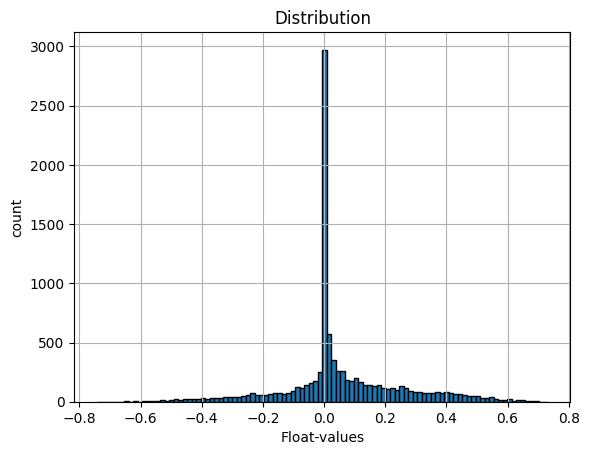

7123 2877


In [27]:
diff = []
for cifar_result, bootstrap_result in zip(cifar_ensemble_conf, result_dict_conf["epoch_150_seed_"]):
    diff.append(cifar_result[1] - bootstrap_result[1])
ergebnis_plot(diff)

positiv = 0
negativ = 0
for i in diff:
    if i < 0:
        negativ += 1
    else:
        positiv += 1
print(positiv, negativ)

### 250

#### distribution all datapoints

mean 0.8350272179906313
std 0.2004962160934229
var 0.04019873266778054


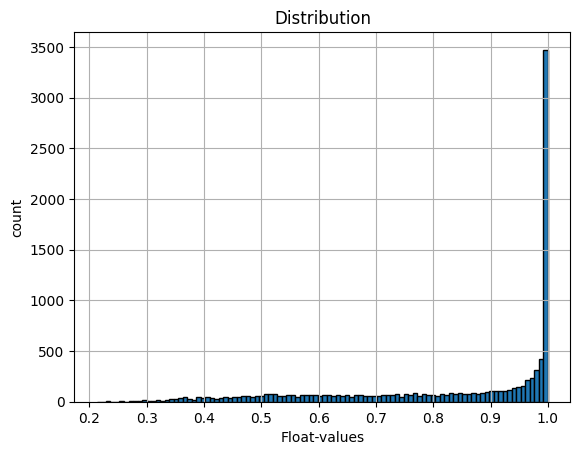

In [38]:
ergebnis_plot([i [1] for i in result_dict_conf["epoch_250_seed_"]])

#### distribution correctly classified

mean 0.894965049999103
std 0.16208161671003446
var 0.026270450475338526


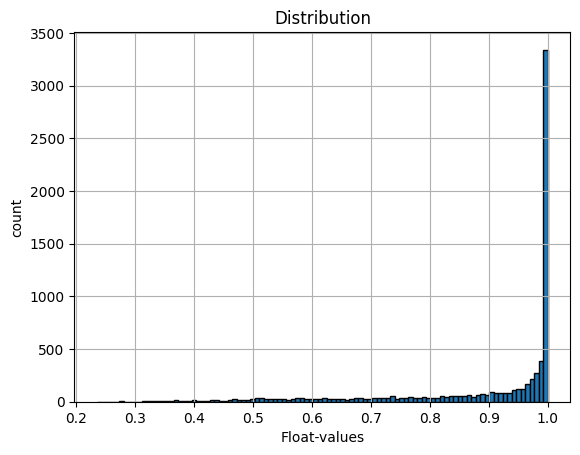

In [39]:
richtiges_label = []
for label, output in zip(test_data_y, result_dict_conf["epoch_250_seed_"]):
    if label == output[0]:
        richtiges_label.append(output[1])
ergebnis_plot(richtiges_label)

#### distribution of misclassified

mean 0.6628278230104447
std 0.20059993382449892
var 0.040240333450393344


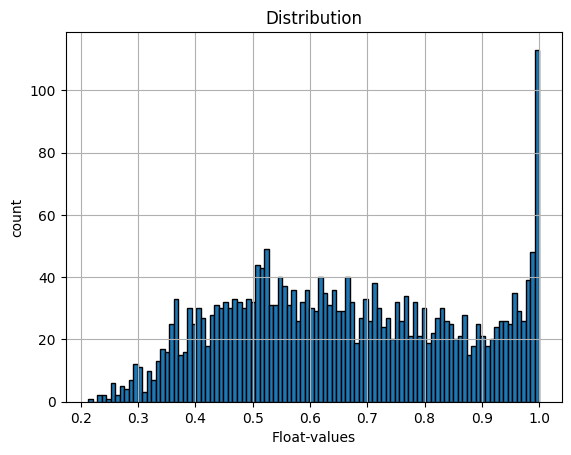

In [40]:
falsches_label = []
for label, output in zip(test_data_y, result_dict_conf["epoch_250_seed_"]):
    if label != output[0]:
        falsches_label.append(output[1])
ergebnis_plot(falsches_label)

Distribution difference to cifar5m ensemble models

mean 0.04596853879695569
std 0.19630404520455433
var 0.038535278163671714


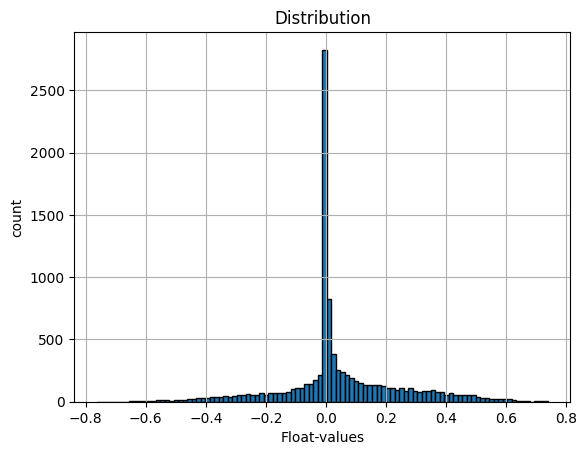

6860 3140


In [41]:
diff = []
for cifar_result, bootstrap_result in zip(cifar_ensemble_conf, result_dict_conf["epoch_250_seed_"]):
    diff.append(cifar_result[1] - bootstrap_result[1])
ergebnis_plot(diff)

positiv = 0
negativ = 0
for i in diff:
    if i < 0:
        negativ += 1
    else:
        positiv += 1
print(positiv, negativ)

### 500

#### Distribution all datapoints

mean 0.8386249476500045
std 0.19987318944352458
var 0.03994929185832707


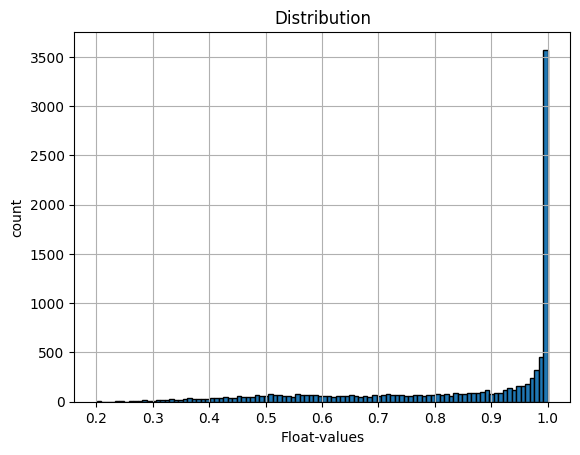

In [42]:
ergebnis_plot([i [1] for i in result_dict_conf["epoch_500_seed_"]])

#### Distribution of correctly classified

mean 0.8989069859083048
std 0.15826912263530465
var 0.0250491151797491


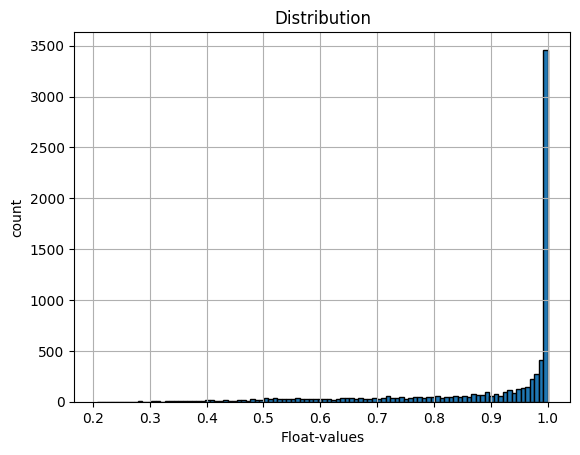

In [43]:
richtiges_label = []
for label, output in zip(test_data_y, result_dict_conf["epoch_500_seed_"]):
    if label == output[0]:
        richtiges_label.append(output[1])
ergebnis_plot(richtiges_label)

#### Distribution of misclassified

mean 0.6600716520798567
std 0.2035638959333921
var 0.041438259727580896


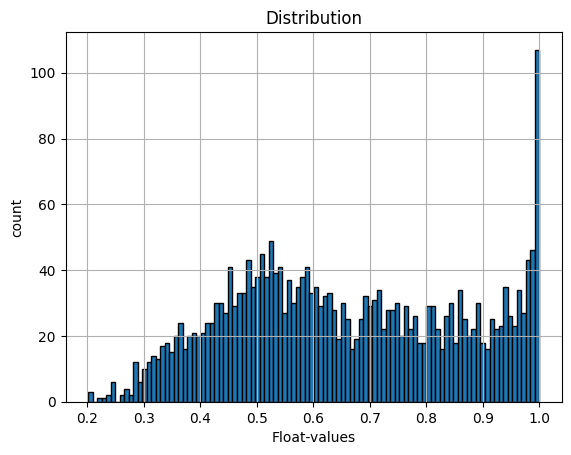

In [44]:
falsches_label = []
for label, output in zip(test_data_y, result_dict_conf["epoch_500_seed_"]):
    if label != output[0]:
        falsches_label.append(output[1])
ergebnis_plot(falsches_label)

#### Distribution difference to cifar5m ensemble models

mean 0.04237080913758256
std 0.19216368244994453
var 0.03692688085272312


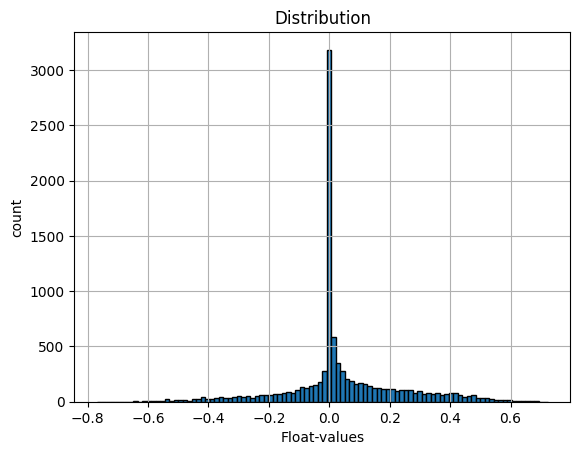

6855 3145


In [45]:
diff = []
for cifar_result, bootstrap_result in zip(cifar_ensemble_conf, result_dict_conf["epoch_500_seed_"]):
    diff.append(cifar_result[1] - bootstrap_result[1])
ergebnis_plot(diff)

positiv = 0
negativ = 0
for i in diff:
    if i < 0:
        negativ += 1
    else:
        positiv += 1
print(positiv, negativ)

### 700

#### Distribution all datapoints

mean 0.8951191307025154
std 0.1682065116411906
var 0.02829343055849799


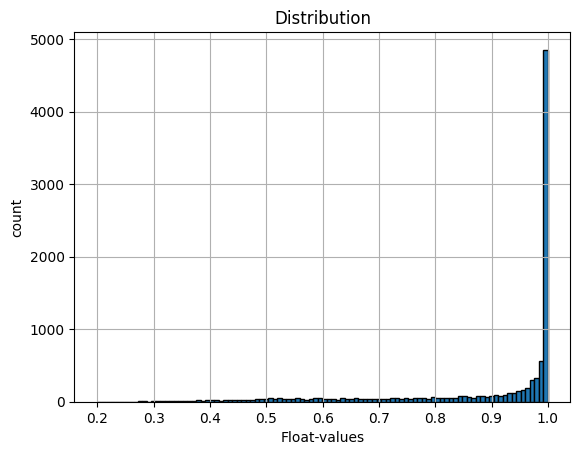

In [63]:
ergebnis_plot([i [1] for i in result_dict_conf["epoch_700_seed_"]])

#### Distribution of correctly classified

mean 0.8952139286728805
std 0.16051578407158243
var 0.025765316936114873


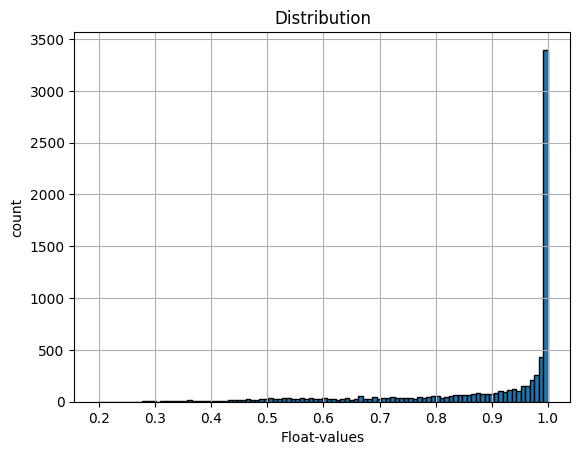

In [33]:
richtiges_label = []
for label, output in zip(test_data_y, result_dict_conf["epoch_700_seed_"]):
    if label == output[0]:
        richtiges_label.append(output[1])
ergebnis_plot(richtiges_label)

#### Distribution of misclassified

mean 0.6526050417908507
std 0.19844644591858143
var 0.03938099189771647


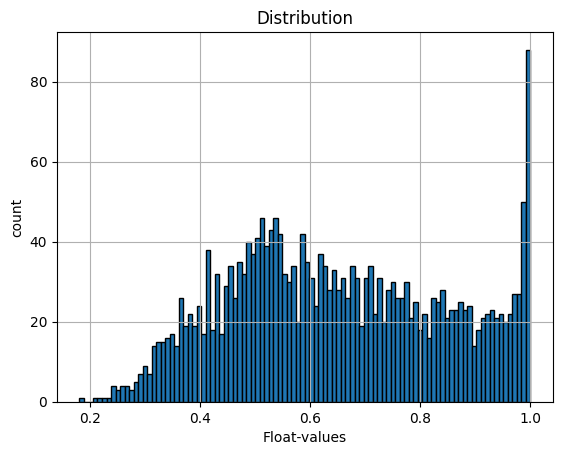

In [28]:
falsches_label = []
for label, output in zip(test_data_y, result_dict_conf["epoch_700_seed_"]):
    if label != output[0]:
        falsches_label.append(output[1])
ergebnis_plot(falsches_label)

#### Distribution difference to cifar5m ensemble models

mean 0.0436683085247588
std 0.18988397915142974
var 0.0360559255383806


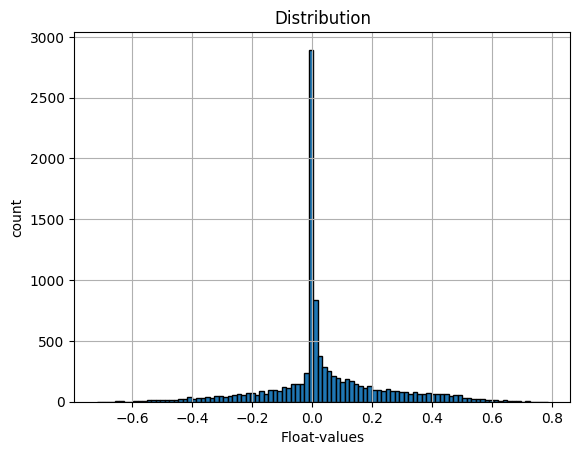

6918 3082


In [85]:
diff = []
diff_kn = []
diff_gn = []
for cifar_result, bootstrap_result in zip(cifar_ensemble_conf, result_dict_conf["epoch_700_seed_"]):
    res = cifar_result[1] - bootstrap_result[1]
    diff.append(res)
    if res < 0:
        diff_kn.append(res)
    else:
        diff_gn.append(res)
ergebnis_plot(diff)

positiv = 0
negativ = 0
for i in diff:
    if i < 0:
        negativ += 1
    else:
        positiv += 1
print(positiv, negativ)

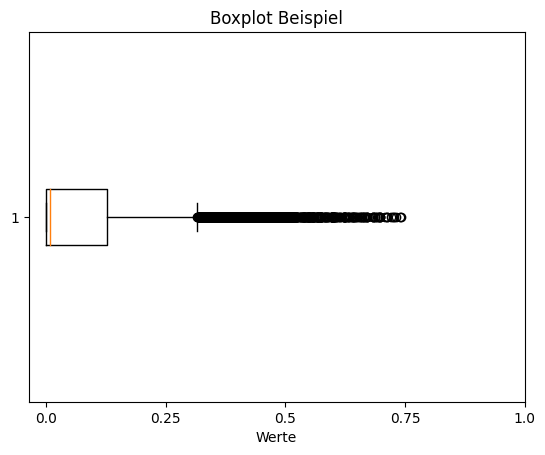

In [68]:
data = diff_gn
plt.boxplot([data], vert=False)  # vert=False dreht den Boxplot um 90 Grad
# Anpassung der x-Achsenbeschriftungen in regelmäßigen Abständen von 0 bis 1
num_ticks = 5  # Anzahl der gewünschten Beschriftungen
xtick_positions = np.linspace(0, 1, num_ticks)
xtick_labels = [str(round(pos, 2)) for pos in xtick_positions]
plt.xticks(xtick_positions, xtick_labels)
plt.title('Boxplot Beispiel')
plt.xlabel('Werte')
plt.show()

### deep ensemble

#### Distribution all datapoints

mean 0.9467745532306355
std 0.1232750303775059
var 0.015196733114575003


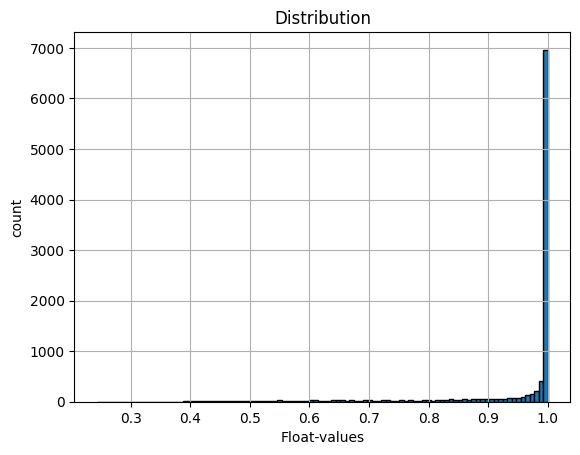

In [64]:
ergebnis_plot([i [1] for i in other_cifar_ensemble_conf])

#### Distribution of correctly classified

mean 0.9245558735742908
std 0.13970494657396113
var 0.01951747209723333


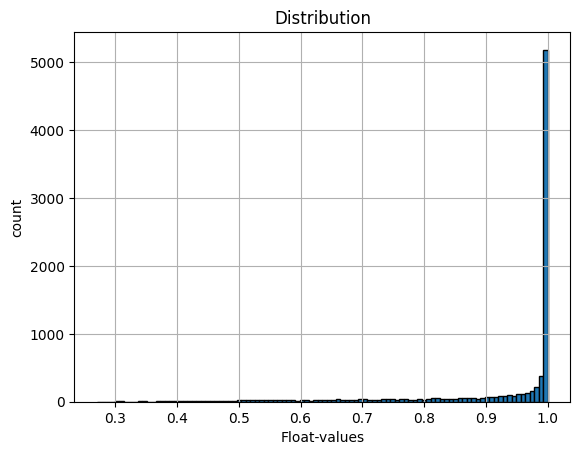

In [31]:
richtiges_label = []
for label, output in zip(test_data_y, other_cifar_ensemble_conf):
    if label == output[0]:
        richtiges_label.append(output[1])
ergebnis_plot(richtiges_label)

#### Distribution of misclassified

mean 0.6114247005267073
std 0.1798356302337045
var 0.032340853901553696


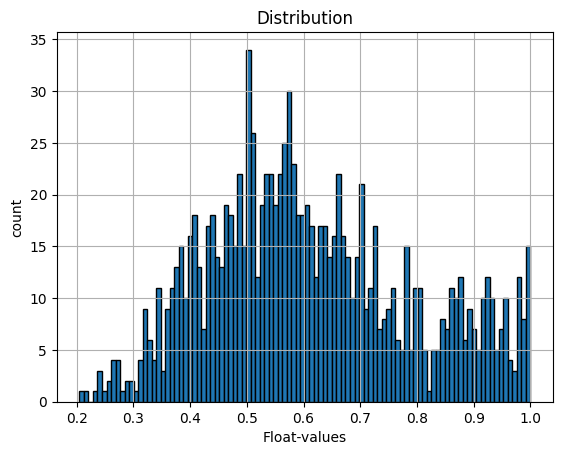

In [30]:
falsches_label = []
for label, output in zip(test_data_y, other_cifar_ensemble_conf):
    if label != output[0]:
        falsches_label.append(output[1])
ergebnis_plot(falsches_label)

#### Distribution difference to cifar5m ensemble models

mean -0.008051041763107832
std 0.09683312184225805
var 0.009376653485717592


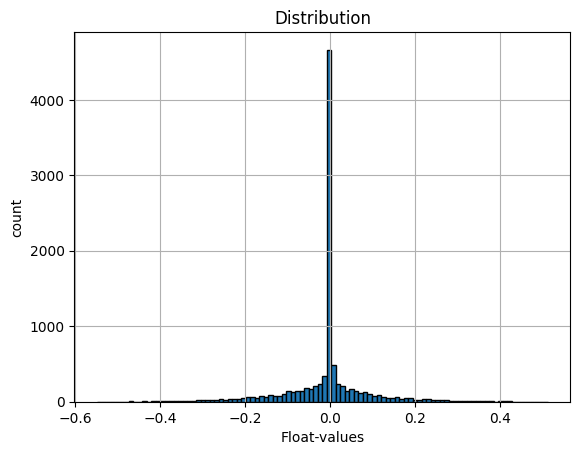

4387 5613


In [86]:
diff = []
for cifar_result, bootstrap_result in zip(cifar_ensemble_conf, other_cifar_ensemble_conf):
    diff.append(cifar_result[1] - bootstrap_result[1])
ergebnis_plot(diff)

positiv = 0
negativ = 0
for i in diff:
    if i < 0:
        negativ += 1
    else:
        positiv += 1
print(positiv, negativ)

### cifar

#### Distribution all datapoints

mean 0.880995756787587
std 0.18286936319047456
var 0.03344120399368969


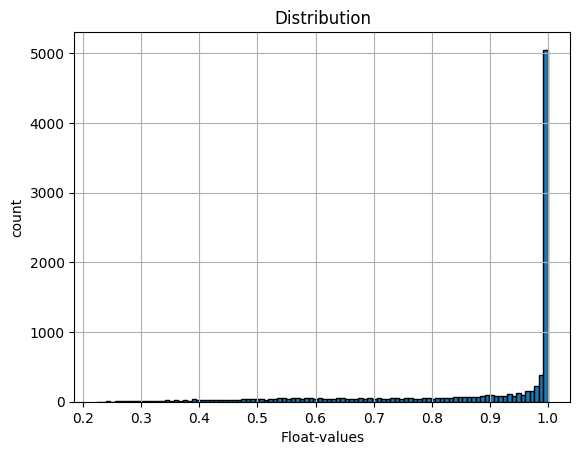

In [54]:
ergebnis_plot([i [1] for i in cifar_ensemble_conf])

#### Distribution of correctly classified

mean 0.9165120401545956
std 0.14795381728501472
var 0.021890332049207522


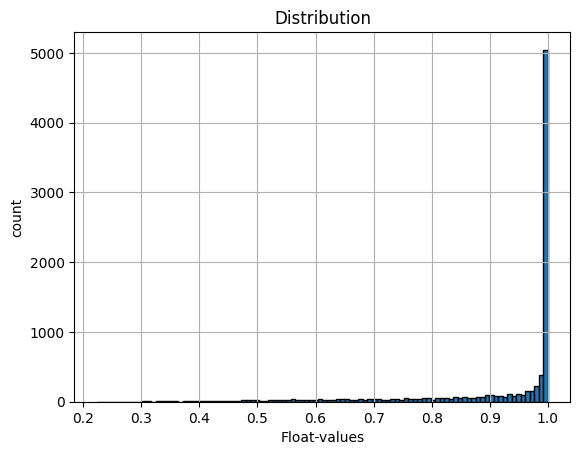

In [32]:
richtiges_label = []
for label, output in zip(test_data_y, cifar_ensemble_conf):
    if label == output[0]:
        richtiges_label.append(output[1])
ergebnis_plot(richtiges_label)

#### Distribution of misclassified

mean 0.5805017907032364
std 0.17378449862869327
var 0.03020105196362629


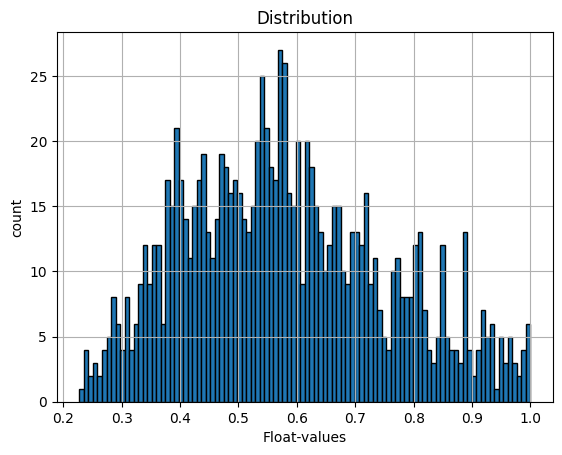

In [29]:
falsches_label = []
for label, output in zip(test_data_y, cifar_ensemble_conf):
    if label != output[0]:
        falsches_label.append(output[1])
ergebnis_plot(falsches_label)

## Einzelne Datenpunkte, direkter Vergleich unsicherheit BI

In [35]:
alle_logits = [logits_150, logits_250, logits_500, logits_700]
key_strings = ["epoch_150_seed_", "epoch_250_seed_", "epoch_500_seed_", "epoch_700_seed_"]
result_dict = {}
for ekato in range(1000):
    for deka in range(10):
        for model_logits, model_key in zip(alle_logits, key_strings):
            #ensemble = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
            ensemble = []
            for model_seed in range(1, 11):
                ein_logit = model_logits[model_key+str(model_seed)][ekato][deka]
                #ensemble += np.array(ein_logit)
                ensemble.append(ein_logit)
            result = float(BI_LSE(torch.tensor(ensemble)))
            #ensemble = ensemble / 10
            if model_key in result_dict:
                result_dict[model_key].append(result)
            else:
                result_dict[model_key] = [result]
cifar_ensemble = []
for ekato in range(1000):
    for deka in range(10):
        #ensemble = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
        ensemble = []
        for model_seed in [1,2,3,4,5,6,7,8,9,11]:
            ein_logit = logits_cifar["cifar_seed_"+str(model_seed)][ekato][deka]
            #ensemble += np.array(ein_logit)
            ensemble.append(ein_logit)
        #ensemble = ensemble / 10
        cifar_ensemble.append(float(BI_LSE(torch.tensor(ensemble))))
other_cifar_ensemble = []
for ekato in range(1000):
    for deka in range(10):
        #ensemble = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0])
        ensemble = []
        for model_seed in range(1,11):
            ein_logit = other_logits_cifar["cifar_seed_"+str(model_seed)][ekato][deka]
            #ensemble += np.array(ein_logit)
            ensemble.append(ein_logit)
        #ensemble = ensemble / 10
        other_cifar_ensemble.append(float(BI_LSE(torch.tensor(ensemble))))

### 150

#### Alle Datenpunkte

mean 0.06557918076515198
std 0.4024944482310308
var 0.16200178085680195


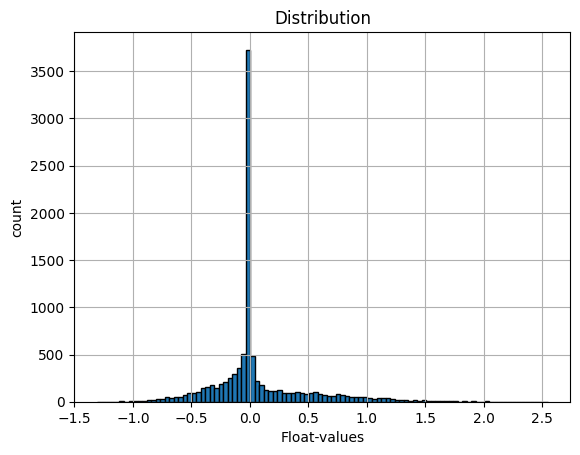

3829 6171


In [36]:
diff = []
for cifar_result, bootstrap_result in zip(cifar_ensemble, result_dict["epoch_150_seed_"]):
    diff.append(cifar_result - bootstrap_result)
ergebnis_plot(diff)

positiv = 0
negativ = 0
for i in diff:
    if i < 0:
        negativ += 1
    else:
        positiv += 1
print(positiv, negativ)

#### Nur richtige

mean -0.01750462765256962
std 0.2589108630729769
var 0.06703483501719379


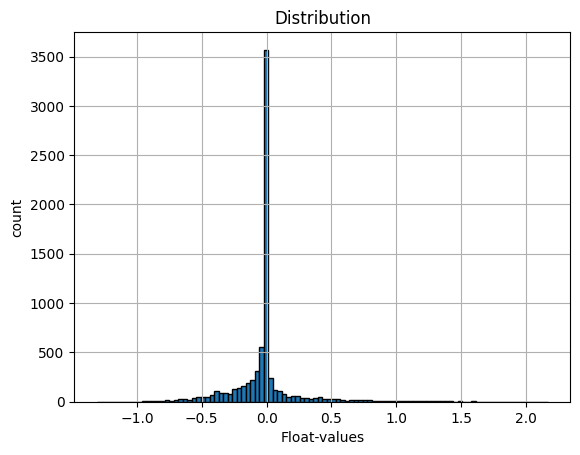

2095 5188


In [37]:
diff = []
for cifar_result, bootstrap_result, model_output, label, cifar_output in zip(cifar_ensemble, result_dict["epoch_150_seed_"], result_dict_acc["epoch_150_seed_"], test_data_y, cifar_ensemble_acc):
    if model_output == label == cifar_output:
        diff.append(cifar_result - bootstrap_result)
ergebnis_plot(diff)

positiv = 0
negativ = 0
for i in diff:
    if i < 0:
        negativ += 1
    else:
        positiv += 1
print(positiv, negativ)

#### Nur Falsche

mean 0.5842052539009853
std 0.5294277968971624
var 0.280293792127383


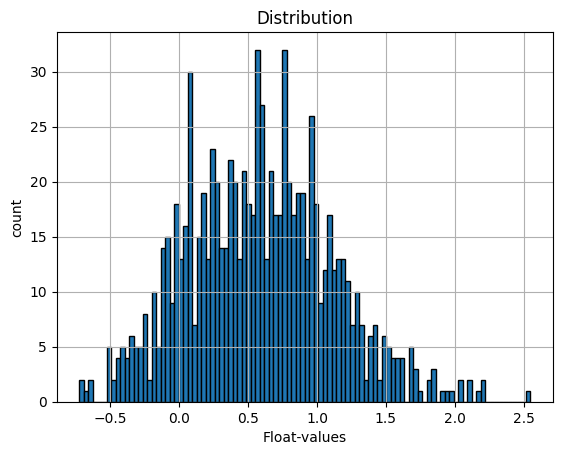

760 124


In [38]:
diff = []
for cifar_result, bootstrap_result, model_output, label, cifar_output in zip(cifar_ensemble, result_dict["epoch_150_seed_"], result_dict_acc["epoch_150_seed_"], test_data_y, cifar_ensemble_acc):
    if model_output != label and cifar_output != label:
        diff.append(cifar_result - bootstrap_result)
ergebnis_plot(diff)

positiv = 0
negativ = 0
for i in diff:
    if i < 0:
        negativ += 1
    else:
        positiv += 1
print(positiv, negativ)

### 250

#### Alle Datenpunkte

mean 0.07157870872020722
std 0.4004005486354513
var 0.16032059934757042


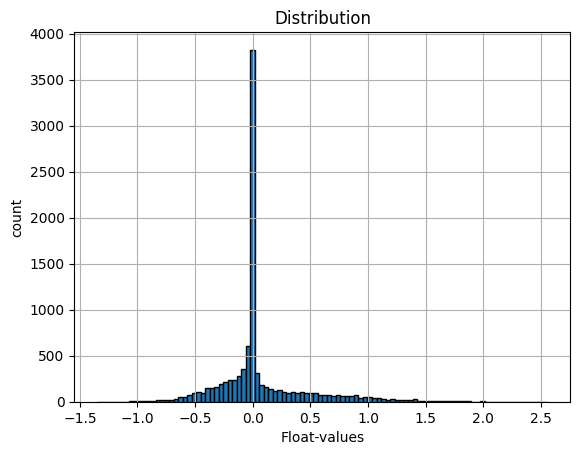

4058 5942


In [30]:
diff = []
for cifar_result, bootstrap_result in zip(cifar_ensemble, result_dict["epoch_250_seed_"]):
    diff.append(cifar_result - bootstrap_result)
ergebnis_plot(diff)

positiv = 0
negativ = 0
for i in diff:
    if i < 0:
        negativ += 1
    else:
        positiv += 1
print(positiv, negativ)

#### Nur richtige

mean -0.012282933470105034
std 0.25845257498602214
var 0.0667977335169054


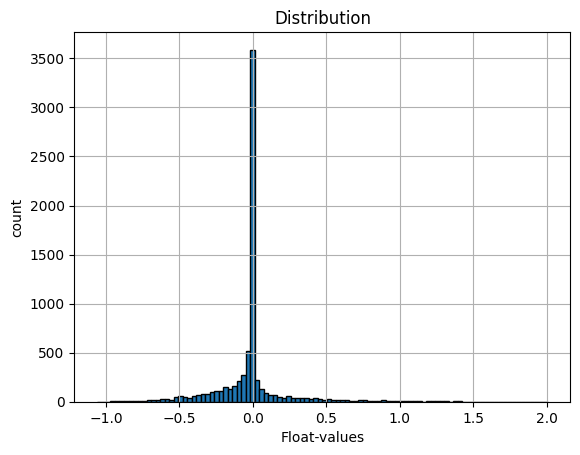

2287 4971


In [40]:
diff = []
for cifar_result, bootstrap_result, model_output, label, cifar_output in zip(cifar_ensemble, result_dict["epoch_250_seed_"], result_dict_acc["epoch_250_seed_"], test_data_y, cifar_ensemble_acc):
    if model_output == label == cifar_output:
        diff.append(cifar_result - bootstrap_result)
ergebnis_plot(diff)

positiv = 0
negativ = 0
for i in diff:
    if i < 0:
        negativ += 1
    else:
        positiv += 1
print(positiv, negativ)

#### Nur falsche

mean 0.589422272997955
std 0.5320645011359699
var 0.2830926333690686


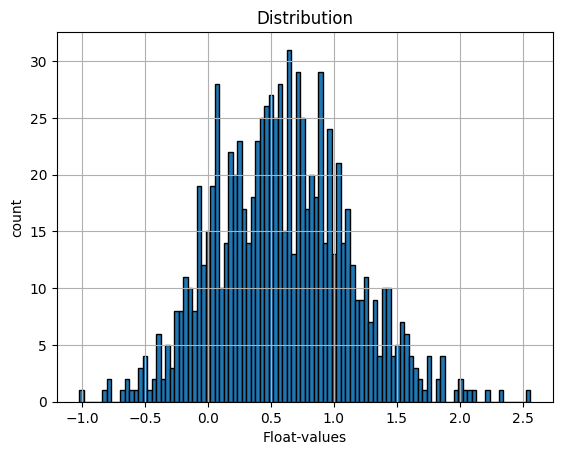

780 117


In [41]:
diff = []
for cifar_result, bootstrap_result, model_output, label, cifar_output in zip(cifar_ensemble, result_dict["epoch_250_seed_"], result_dict_acc["epoch_250_seed_"], test_data_y, cifar_ensemble_acc):
    if model_output != label and cifar_output != label:
        diff.append(cifar_result - bootstrap_result)
ergebnis_plot(diff)

positiv = 0
negativ = 0
for i in diff:
    if i < 0:
        negativ += 1
    else:
        positiv += 1
print(positiv, negativ)

### 500

#### Alle Datenpunkte

mean 0.07170502893924713
std 0.3967711690753876
var 0.1574273606094498


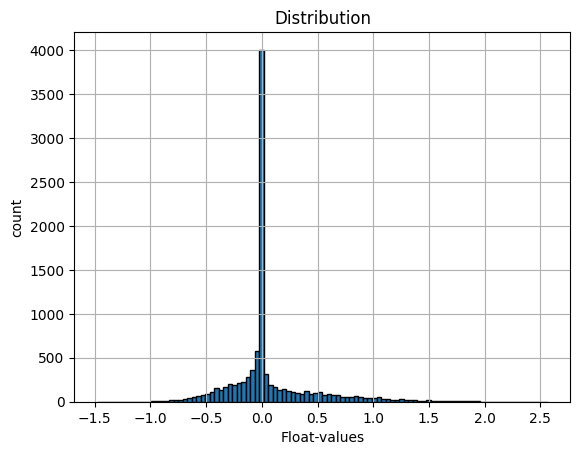

4077 5923


In [34]:
diff = []
for cifar_result, bootstrap_result in zip(cifar_ensemble, result_dict["epoch_500_seed_"]):
    diff.append(cifar_result - bootstrap_result)
ergebnis_plot(diff)

positiv = 0
negativ = 0
for i in diff:
    if i < 0:
        negativ += 1
    else:
        positiv += 1
print(positiv, negativ)

#### Nur richtige

mean -0.008097068351378427
std 0.2536412481719079
var 0.06433388277420339


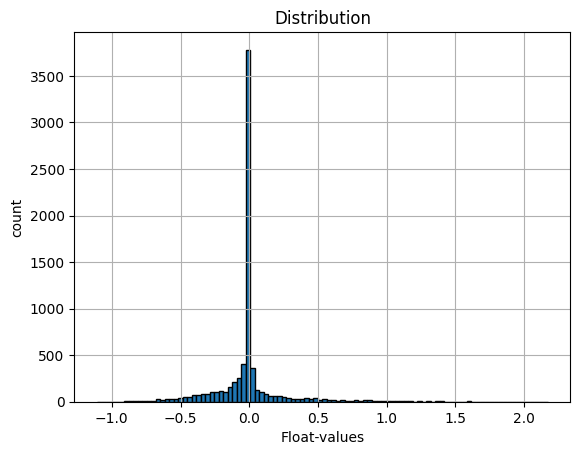

2347 4967


In [42]:
diff = []
for cifar_result, bootstrap_result, model_output, label, cifar_output in zip(cifar_ensemble, result_dict["epoch_500_seed_"], result_dict_acc["epoch_500_seed_"], test_data_y, cifar_ensemble_acc):
    if model_output == label == cifar_output:
        diff.append(cifar_result - bootstrap_result)
ergebnis_plot(diff)

positiv = 0
negativ = 0
for i in diff:
    if i < 0:
        negativ += 1
    else:
        positiv += 1
print(positiv, negativ)

#### Nur falsche

mean 0.5868652426330737
std 0.5322351886665548
var 0.28327429605492327


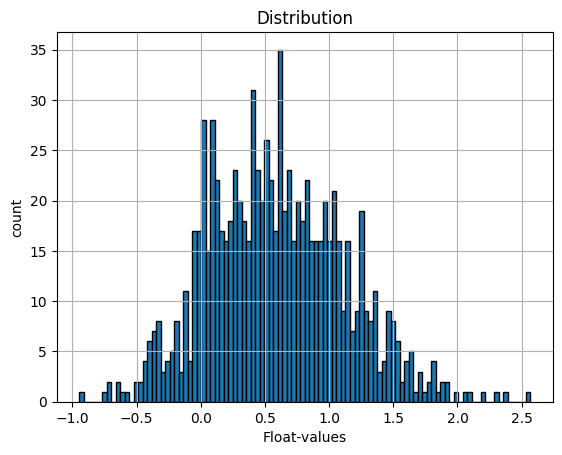

787 108


In [43]:
diff = []
for cifar_result, bootstrap_result, model_output, label, cifar_output in zip(cifar_ensemble, result_dict["epoch_500_seed_"], result_dict_acc["epoch_500_seed_"], test_data_y, cifar_ensemble_acc):
    if model_output != label and cifar_output != label:
        diff.append(cifar_result - bootstrap_result)
ergebnis_plot(diff)

positiv = 0
negativ = 0
for i in diff:
    if i < 0:
        negativ += 1
    else:
        positiv += 1
print(positiv, negativ)

### 700

#### Alle Datenpunkte

mean 0.059673072957992554
std 0.3960400446716258
var 0.15684771698350336


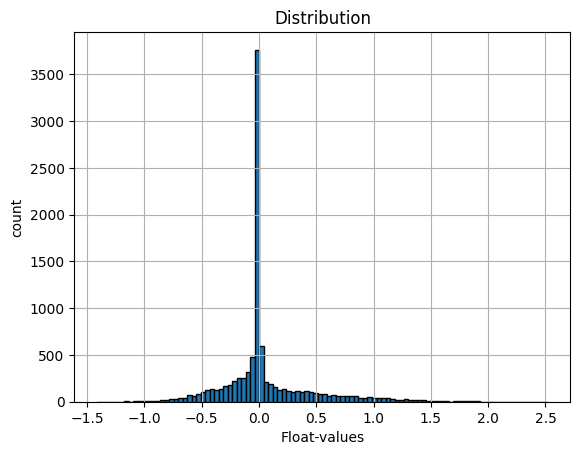

3966 6034


In [28]:
diff = []
for cifar_result, bootstrap_result in zip(cifar_ensemble, result_dict["epoch_700_seed_"]):
    diff.append(cifar_result - bootstrap_result)
ergebnis_plot(diff)

positiv = 0
negativ = 0
for i in diff:
    if i < 0:
        negativ += 1
    else:
        positiv += 1
print(positiv, negativ)

#### Nur richtige

mean -0.012779017128993184
std 0.26482332318963864
var 0.07013139250520381


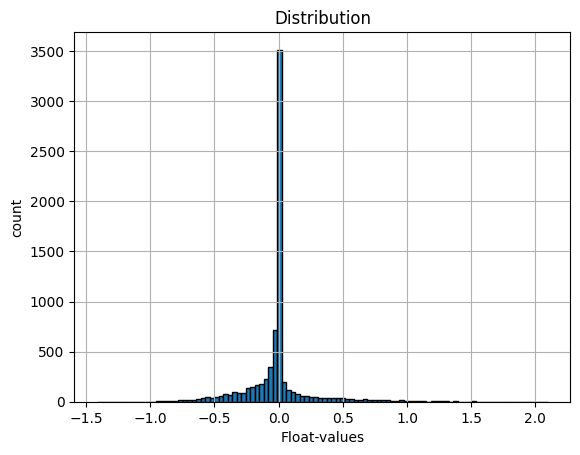

2300 5128


In [44]:
diff = []
for cifar_result, bootstrap_result, model_output, label, cifar_output in zip(cifar_ensemble, result_dict["epoch_700_seed_"], result_dict_acc["epoch_700_seed_"], test_data_y, cifar_ensemble_acc):
    if model_output == label == cifar_output:
        diff.append(cifar_result - bootstrap_result)
ergebnis_plot(diff)

positiv = 0
negativ = 0
for i in diff:
    if i < 0:
        negativ += 1
    else:
        positiv += 1
print(positiv, negativ)

#### Nur falsche

mean 0.5515323514642726
std 0.5193530084635296
var 0.26972754740011906


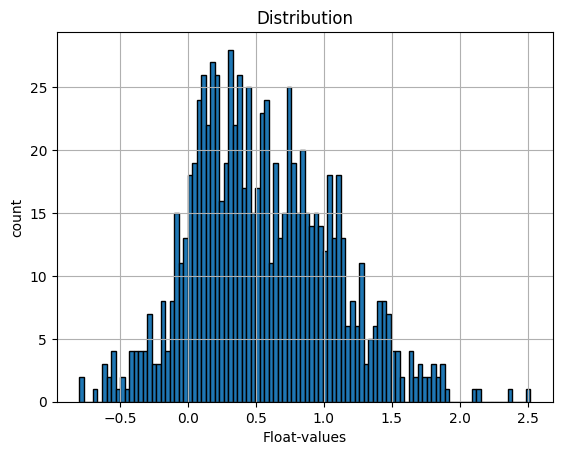

766 105


In [45]:
diff = []
for cifar_result, bootstrap_result, model_output, label, cifar_output in zip(cifar_ensemble, result_dict["epoch_700_seed_"], result_dict_acc["epoch_700_seed_"], test_data_y, cifar_ensemble_acc):
    if model_output != label and cifar_output != label:
        diff.append(cifar_result - bootstrap_result)
ergebnis_plot(diff)

positiv = 0
negativ = 0
for i in diff:
    if i < 0:
        negativ += 1
    else:
        positiv += 1
print(positiv, negativ)

### deep ensemble

#### alle Datenpunkte

mean 0.04525128321647644
std 0.28448358697497833
var 0.08093091125815005


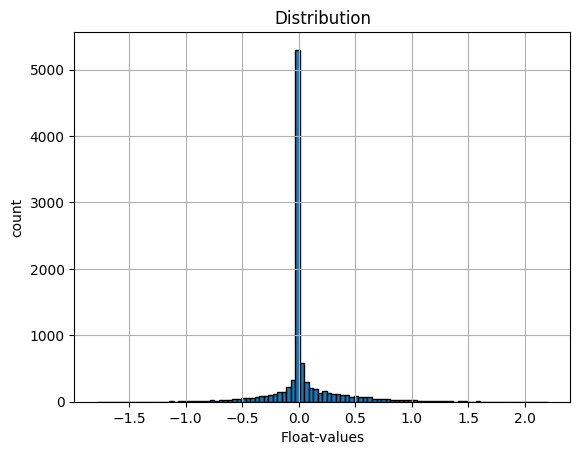

5935 4065


In [40]:
diff = []
for cifar_result, bootstrap_result in zip(cifar_ensemble, other_cifar_ensemble):
    diff.append(cifar_result - bootstrap_result)
ergebnis_plot(diff)

positiv = 0
negativ = 0
for i in diff:
    if i < 0:
        negativ += 1
    else:
        positiv += 1
print(positiv, negativ)

#### nur richtige

mean 0.0245737978002929
std 0.2323853333988374
var 0.05400294317888881


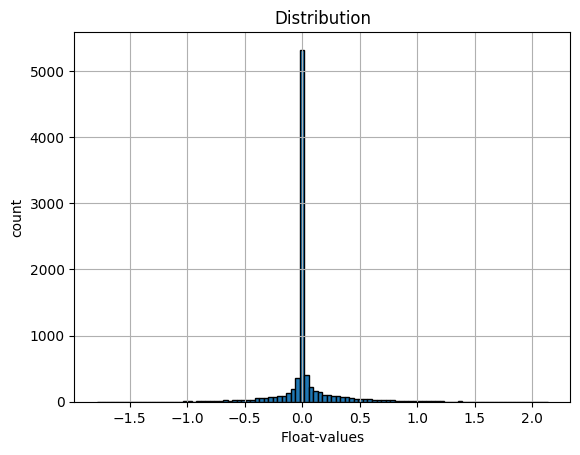

5081 3580


In [46]:
diff = []
for cifar_result, bootstrap_result, model_output, label, cifar_output in zip(cifar_ensemble, other_cifar_ensemble, other_cifar_ensemble_acc, test_data_y, cifar_ensemble_acc):
    if model_output == label == cifar_output:
        diff.append(cifar_result - bootstrap_result)
ergebnis_plot(diff)

positiv = 0
negativ = 0
for i in diff:
    if i < 0:
        negativ += 1
    else:
        positiv += 1
print(positiv, negativ)

mean 0.1835007412892552
std 0.4746557853870648
var 0.22529811460141133


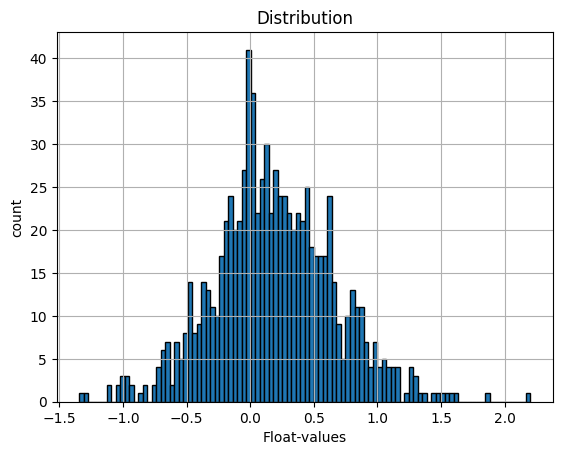

552 300


In [47]:
diff = []
for cifar_result, bootstrap_result, model_output, label, cifar_output in zip(cifar_ensemble, other_cifar_ensemble, other_cifar_ensemble_acc, test_data_y, cifar_ensemble_acc):
    if model_output != label and cifar_output != label:
        diff.append(cifar_result - bootstrap_result)
ergebnis_plot(diff)

positiv = 0
negativ = 0
for i in diff:
    if i < 0:
        negativ += 1
    else:
        positiv += 1
print(positiv, negativ)